   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 6.1 MB/s eta 0:00:00
Dataset shape: (150, 4)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2



=== Base Models (Test Accuracy) ===
KNN: 0.8947
SVM: 0.9211
Logistic Regression: 0.8947


[I 2025-12-15 15:23:51,368] A new study created in memory with name: no-name-db5ee8d9-3f3d-4eb1-8b2d-7ce26320d161


XGBoost: 0.9211

=== Optuna Tuning for XGBoost (5-fold CV) ===


[I 2025-12-15 15:23:51,554] Trial 0 finished with value: 0.9193675889328062 and parameters: {'n_estimators': 93, 'max_depth': 9, 'learning_rate': 0.201995720382539, 'subsample': 0.9285484362735483, 'colsample_bytree': 0.8180070539598253, 'gamma': 4.237175907440069, 'reg_alpha': 4.532119704597289, 'reg_lambda': 4.845433767379296}. Best is trial 0 with value: 0.9193675889328062.
[I 2025-12-15 15:23:51,744] Trial 1 finished with value: 0.9375494071146244 and parameters: {'n_estimators': 134, 'max_depth': 7, 'learning_rate': 0.16409404120399126, 'subsample': 0.7803522439425026, 'colsample_bytree': 0.6254958182203886, 'gamma': 2.093403354161692, 'reg_alpha': 4.619411461926929, 'reg_lambda': 2.3416318496874995}. Best is trial 1 with value: 0.9375494071146244.
[I 2025-12-15 15:23:52,086] Trial 2 finished with value: 0.9284584980237154 and parameters: {'n_estimators': 276, 'max_depth': 7, 'learning_rate': 0.2948376775951552, 'subsample': 0.7738294631369421, 'colsample_bytree': 0.93080632291153

Best Parameters: {'n_estimators': 156, 'max_depth': 5, 'learning_rate': 0.010069894496277265, 'subsample': 0.735086911267025, 'colsample_bytree': 0.6372714661776603, 'gamma': 0.3854410981350266, 'reg_alpha': 3.1385881705507463, 'reg_lambda': 3.6953453324599015}
Best CV Accuracy: 0.9553

=== Tuned XGBoost (Test Set Performance) ===
Accuracy: 0.9210526315789473
F1 Score (weighted): 0.9209356725146198

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       0.86      0.92      0.89        13
   virginica       0.92      0.85      0.88        13

    accuracy                           0.92        38
   macro avg       0.92      0.92      0.92        38
weighted avg       0.92      0.92      0.92        38


=== GridSearchCV for SVM (5-fold CV) ===
Best Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best CV Accuracy: 0.9731
Test Accuracy (Best SVM): 0.9210526315789473


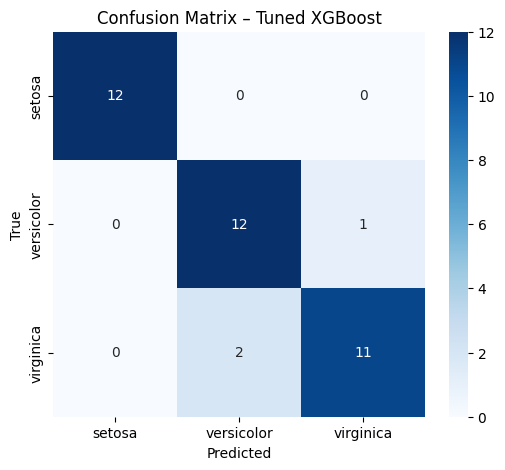


=== Final Test Accuracies ===
KNN (base): 0.8947
SVM (base): 0.9211
Logistic Regression (base): 0.8947
XGBoost (base): 0.9211
XGBoost (tuned): 0.9211
SVM (grid search): 0.9211


In [6]:
!pip install optuna xgboost seaborn scikit-learn matplotlib pandas numpy
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
# %matplotlib inline  # Uncomment in Jupyter if plots don't display automatically

# 1. LOAD DATA
data = load_iris()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

print("Dataset shape:", X.shape)
display(X.head())  # Better display in notebooks

# 2. FEATURE ENGINEERING
X['sepal_ratio'] = X['sepal length (cm)'] / X['sepal width (cm)']
X['petal_ratio'] = X['petal length (cm)'] / X['petal width (cm)']

# 3. STANDARDIZATION
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. TRAIN-TEST SPLIT (with stratification)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=y
)

# 5. BASE MODELS
models = {
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=300),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', random_state=42)
}

results = {}
print("\n=== Base Models (Test Accuracy) ===")
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    results[name] = acc
    print(f"{name}: {acc:.4f}")

# 6. OPTUNA HYPERPARAMETER TUNING FOR XGBoost (using cross-validation)
print("\n=== Optuna Tuning for XGBoost (5-fold CV) ===")

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
    }
    model = XGBClassifier(**params, eval_metric='mlogloss', random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best Parameters:", study.best_params)
print("Best CV Accuracy:", f"{study.best_value:.4f}")

# 7. TRAIN BEST XGBoost MODEL
best_xgb = XGBClassifier(**study.best_params, eval_metric='mlogloss', random_state=42)
best_xgb.fit(X_train, y_train)
xgb_preds = best_xgb.predict(X_test)

print("\n=== Tuned XGBoost (Test Set Performance) ===")
print("Accuracy:", accuracy_score(y_test, xgb_preds))
print("F1 Score (weighted):", f1_score(y_test, xgb_preds, average='weighted'))
print("\nClassification Report:")
print(classification_report(y_test, xgb_preds, target_names=data.target_names))

# 8. GRIDSEARCHCV FOR SVM
print("\n=== GridSearchCV for SVM (5-fold CV) ===")
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1]
}
grid = GridSearchCV(SVC(random_state=42), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best CV Accuracy:", f"{grid.best_score_:.4f}")

svm_preds = grid.best_estimator_.predict(X_test)
print("Test Accuracy (Best SVM):", accuracy_score(y_test, svm_preds))

# 9. CONFUSION MATRIX (for tuned XGBoost)
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, xgb_preds), annot=True, fmt='d', cmap="Blues",
            xticklabels=data.target_names, yticklabels=data.target_names)
plt.title("Confusion Matrix – Tuned XGBoost")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 10. FINAL COMPARISON
print("\n=== Final Test Accuracies ===")
for name, acc in results.items():
    print(f"{name} (base): {acc:.4f}")
print(f"XGBoost (tuned): {accuracy_score(y_test, xgb_preds):.4f}")
print(f"SVM (grid search): {accuracy_score(y_test, svm_preds):.4f}")